In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from globals import BASE_DIR
dataset = "yelp"

DATASET_DIR = f"{BASE_DIR}{dataset}_dataset/"


In [8]:
user_events = pd.read_csv(DATASET_DIR  + f"processed_data_recbole_debias/{dataset}_sample.train.inter", sep="\t")

In [9]:
user_events

,user_id:token,item_id:token,checkin_count:float
0,0_x,813_x,1
1,0_x,783_x,1
2,0_x,520_x,1
3,0_x,68_x,1
4,0_x,2464_x,1
...,...,...,...
21186,9_x,2819_x,1
21187,9_x,712_x,1
21188,9_x,4089_x,1
21189,9_x,9_x,1


In [10]:
user_events["checkin_count:float"].max()

11

In [11]:

user_events = pd.read_csv(DATASET_DIR  + f"processed_data_recbole/{dataset}_sample.inter", sep="\t")
high_pop_users = pd.read_csv(DATASET_DIR  + "processed_data_cornac/high_pop_user_sample.csv")
med_pop_users = pd.read_csv(DATASET_DIR + "processed_data_cornac/medium_pop_user_sample.csv")
low_pop_users = pd.read_csv(DATASET_DIR  + "processed_data_cornac/low_pop_user_sample.csv")


# user_events = pd.read_csv(DATASET_DIR, encoding="latin1", sep=";", header=None, names=["timestamp", "user_id", "region_id", "region_name", "business_id", "card_type"])

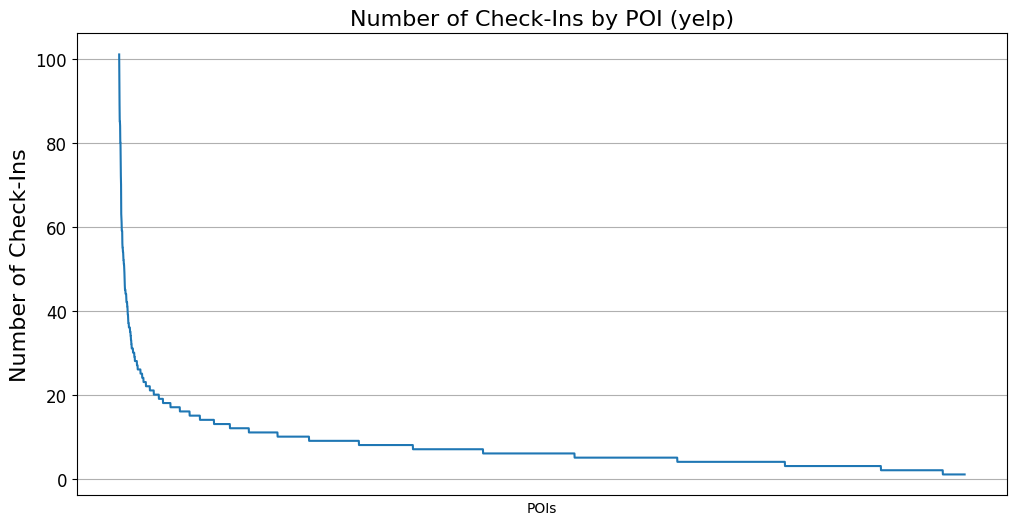

In [12]:
user_events["item_id:token"].astype(str).value_counts().plot(figsize=(12, 6), linestyle='-')


plt.xlabel('POIs')
plt.title(f'Number of Check-Ins by POI ({dataset})', fontsize=16)
plt.ylabel('Number of Check-Ins', fontsize=16)
plt.grid(True)

plt.xticks([])

plt.yticks(fontsize=12)  



plt.savefig(f'{DATASET_DIR}/plots/Number of Check-Ins by POI ({dataset})', dpi=300)


In [13]:
# user distribution
user_dist = user_events["user_id:token"].value_counts()
num_users = user_dist.shape[0]
print("Mean (different) POI check-ins per User: ", user_events["user_id:token"].value_counts().mean())
print("Min (different) POI check-ins per User: ", user_events["user_id:token"].value_counts().min())
print("Max (different) POI check-ins per User: ", user_events["user_id:token"].value_counts().max())
print("Number of users: ", num_users)

# item distribution
item_dist = user_events["item_id:token"].value_counts()
num_items = item_dist.shape[0]
print("Number of POIs (items): ", num_items)

# sparsity
print("Sparsity:", 1 - len(user_events) / (len(user_events["user_id:token"].unique()) * len(user_events["item_id:token"].unique())))


Mean (different) POI check-ins per User:  23.21066666666667
Min (different) POI check-ins per User:  10
Max (different) POI check-ins per User:  162
Number of users:  1500
Number of POIs (items):  4510
Sparsity: 0.9948535107169254


In [14]:
len(user_events["user_id:token"].unique())

1500

In [15]:
user_events["item_id:token"].value_counts()

item_id:token
212_x     101
730_x      94
211_x      89
46_x       85
2203_x     85
         ... 
4023_x      1
3740_x      1
2630_x      1
1627_x      1
4318_x      1
Name: count, Length: 4510, dtype: int64

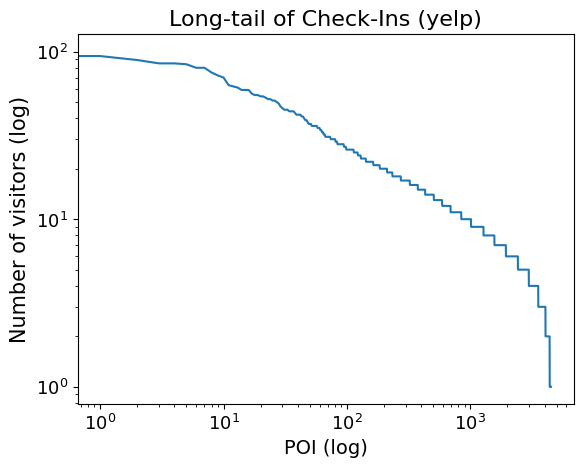

In [16]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values, linestyle='-')
plt.title(f'Long-tail of Check-Ins ({dataset})', fontsize=16)
plt.xlabel('POI (log)', fontsize=14)
plt.ylabel('Number of visitors (log)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig(f'{DATASET_DIR}/plots/Long-tail of Check-Ins ({dataset})', dpi=300)
# plt.savefig('/Volumes/Forster Neu/Masterarbeit Data/snowcard/Long-tail of Check-Ins ({dataset})', dpi=300)


plt.show()


#### Recreating the popularity calculation from: https://github.com/domkowald/FairRecSys/blob/master/LFM_Fairness.ipynb

In [17]:
top_fraction = 0.2
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
no_users = len(high_pop_users) + len(med_pop_users) + len(low_pop_users)
# no_users = len(user_events["user_id"].unique())

In [18]:
# Initialize lists and counters
pop_count = []
user_hist = []
pop_fraq = []
pop_item_fraq = []
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0

# Iterate through each user and calculate detailed metrics
for u, df in user_events.groupby('user_id:token'):
    no_user_items = len(set(df["item_id:token"]))  # Profile size
    no_user_pop_items = len(set(df["item_id:token"]) & set(top_item_dist.index))  # Top items in profile
    
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    
    # Calculate the average popularity of items in the user's profile
    user_pop_item_fraq = sum(item_dist[df["item_id:token"]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    
    # Update group-specific values
    if u in low_pop_users['user_id:token'].values:
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in med_pop_users['user_id:token'].values:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    elif u in high_pop_users['user_id:token'].values:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1

# Calculate average values for each user group (avoid division by zero)
if len(low_pop_users) > 0:
    low_profile_size /= len(low_pop_users)
    low_gap /= len(low_pop_users)
if len(med_pop_users) > 0:
    medium_profile_size /= len(med_pop_users)
    medium_gap /= len(med_pop_users)
if len(high_pop_users) > 0:
    high_profile_size /= len(high_pop_users)
    high_gap /= len(high_pop_users)

# Print results for verification
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))
# average number of unique POIs that users interact with in each popularity group
print('Low profile size: ' + str(low_profile_size))
print('Medium profile size: ' + str(medium_profile_size))
print('High profile size: ' + str(high_profile_size))
print('Low gap: ' + str(low_gap))
print('Medium gap: ' + str(medium_gap))
print('High gap: ' + str(high_gap))

Low count (for check): 500
Med count (for check): 500
High count (for check): 500
Low profile size: 22.392
Medium profile size: 25.624
High profile size: 21.616
Low gap: 0.006409105117030735
Medium gap: 0.00773138311568622
High gap: 0.016338542512966528


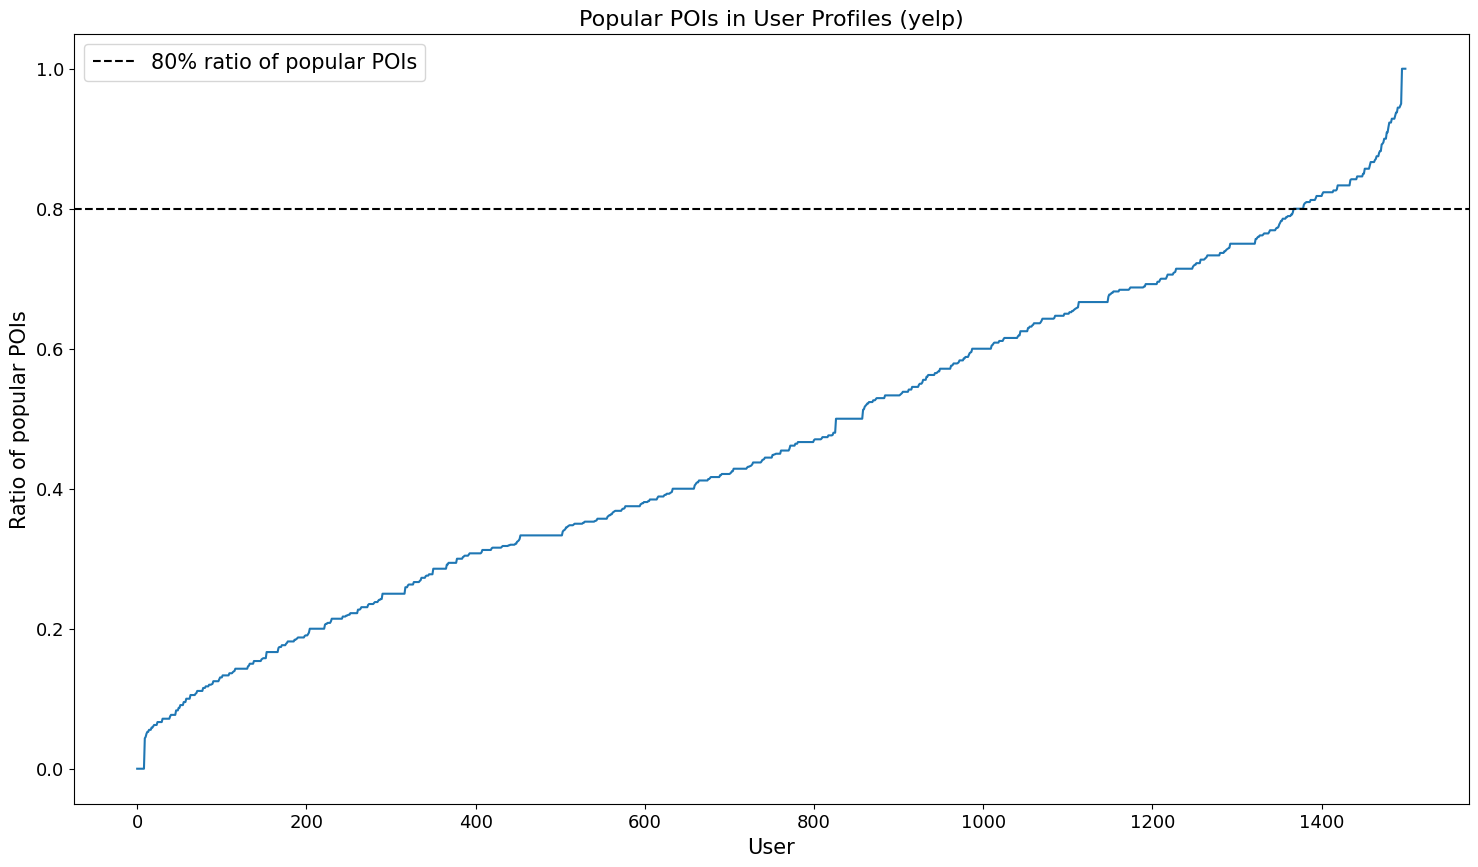

In [19]:
sorted_pop_fraq = sorted(pop_fraq)
plt.figure(figsize=(18, 10))  # Adjust the figure size if needed
plt.plot(sorted_pop_fraq, linestyle='-')
plt.title(f'Popular POIs in User Profiles ({dataset})', fontsize=16)
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular POIs', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular POIs')
plt.legend(fontsize='15')

plt.savefig(f'{DATASET_DIR}/plots/Popular POIs in User Profiles ({dataset})', dpi=300)
# plt.savefig('/Volumes/Forster Neu/Masterarbeit Data/snowcard/Popular POIs in User Profiles ({dataset})', dpi=300)


plt.show()

R-value: 0.7347530839680058
P-value: 8.929854108299043e-255


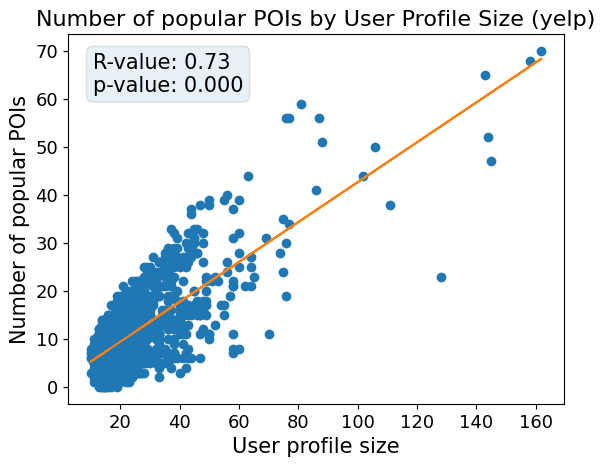

In [20]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
print('P-value: ' + str(p_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.title(f'Number of popular POIs by User Profile Size ({dataset})', fontsize=16) 
plt.xlabel('User profile size', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular POIs', fontsize='15')
plt.yticks(fontsize='13')

# Adding R-value and p-value to the plot
text_str = f'R-value: {r_value:.2f}\np-value: {p_value:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))


plt.savefig(f'{DATASET_DIR}/plots/Number of popular POIs by User Profile Size ({dataset})', dpi=300)
# plt.savefig('/Volumes/Forster Neu/Masterarbeit Data/snowcard/Number of popular POIs by User Profile Size', dpi=300)


R-value: -0.068948014917014
SignificanceResult(statistic=-0.008109564377427676, pvalue=0.7536536500256388)


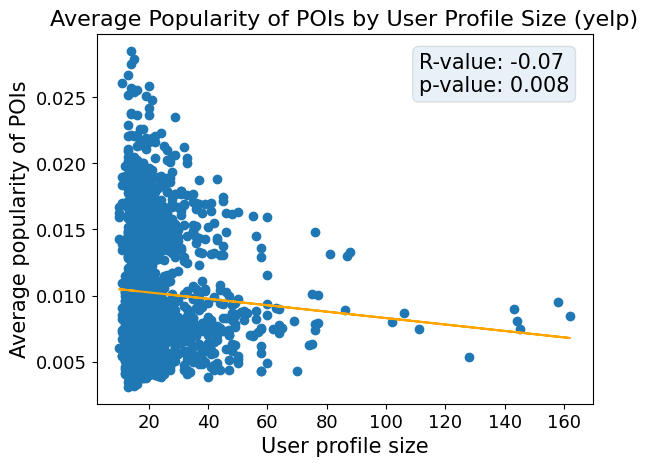

In [21]:
# Create the figure
plt.figure()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))

# Create the line for the regression
line = slope * np.array(user_hist) + intercept

# Plot the data points and the regression line
plt.plot(user_hist, pop_item_fraq, 'o', label='Data Points')
plt.plot(user_hist, line, label='Regression Line', color='orange')

# Title and labels
plt.title(f'Average Popularity of POIs by User Profile Size ({dataset})', fontsize=16) 
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of POIs', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')

# Adding R-value and p-value to the plot
text_str = f'R-value: {r_value:.2f}\np-value: {p_value:.3f}'
plt.text(0.65, 0.95, text_str, transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Save the plot
plt.savefig(f'{DATASET_DIR}/plots/Average Popularity of POIs by User Profile Size ({dataset})', dpi=300)

# Show the plot (optional)
plt.show()
